# Notebook Intro

The objective of this notebook is to measure how consistently one is shooting given a series of shot arcs. 

There are several objectives:
1. Measure similarity between two curves
2. Measure similarity between one curve and a group of curves.

- https://towardsdatascience.com/dynamic-time-warping-3933f25fcdd
- https://www.cs.unm.edu/~mueen/DTW.pdf
- https://stats.stackexchange.com/questions/27861/similarity-measures-between-curves
- http://citeseerx.ist.psu.edu/viewdoc/download;jsessionid=C47D6D8C623AEA6596400C2D0F0DB0A7?doi=10.1.1.118.5078&rep=rep1&type=pdf
- http://alumni.cs.ucr.edu/~mvlachos/pubs/icde02.pdf


- https://github.com/markdregan/K-Nearest-Neighbors-with-Dynamic-Time-Warping
- https://pypi.org/project/fastdtw/
- https://dynamictimewarping.github.io/python/

In [44]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt

from collections import defaultdict


from scipy.spatial.distance import euclidean
from fastdtw import fastdtw



# Process Basketballs Detected into Shot Arc Data Structure

In [179]:
bball_info_df = pd.read_csv("bball_info_df_2.csv", index_col=0)
bball_info_df.head()

,frame_idx,x,y,width,height,is_bball,shot_idx
1596,549,238,323.0,32,32,True,2
1599,552,226,284.0,33,35,True,2
1600,553,222,276.0,30,40,True,2
1601,554,212,271.0,36,40,True,2
1607,557,199,257.0,34,36,True,2


In [180]:
frame_dim = (960.0, 544.0)

In [181]:
shot_arcs = defaultdict(dict)

for name, group in bball_info_df.groupby('shot_idx'):
    shot_arcs[name]['x'] = list(group['x'] + group['width']/2)
    shot_arcs[name]['y'] = list(frame_dim[1] - (group['y'] + group['height']/2))
    shot_arcs[name]['xy'] = list(zip(shot_arcs[name]['x'], shot_arcs[name]['y']))

In [173]:
shot_arcs.keys()

dict_keys([2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 1])

In [174]:
shot_arcs

defaultdict(dict,
            {2: {'x': [254.0,
               242.5,
               237.0,
               230.0,
               216.0,
               269.5,
               287.5,
               306.0,
               323.0,
               339.5,
               357.0,
               373.5,
               390.0,
               406.0,
               422.5,
               439.5,
               455.0,
               472.0,
               487.5,
               503.5,
               520.0,
               535.5,
               551.5,
               567.5,
               583.0,
               598.0,
               614.5,
               630.0,
               646.5,
               663.5,
               678.0,
               711.5],
              'y': [205.0,
               242.5,
               248.0,
               253.0,
               269.0,
               350.0,
               369.5,
               387.5,
               403.5,
               419.5,
               433.5,
               446.0,


# Manually Trim Basketball Shot Arcs to Start After Release and End Before Hits Rim
 This is a temporary Solution for Demo.

In [170]:
trim_shot_arcs = defaultdict(dict)

In [176]:
del shot_arcs[1]

In [184]:
for shot_num, shot_arc in shot_arcs.items():
    shot_arc_x, shot_arc_y = shot_arc['x'], shot_arc['y']
    shot_arc_xy = shot_arc['xy']
    
    
    start_idx, end_idx = -1,-1
    prev_y = 10000000
    for i,y in enumerate(shot_arc_y):
        
#         if prev_y < 300 and y >= 300:
#             start_idx = i
#         if prev_y > 380 and y <= 380:
#             end_idx = i
        if prev_y < 350 and y >= 350:
            start_idx = i
        if prev_y > 420 and y <= 420:
            end_idx = i
            
        prev_y = y
    

    trim_shot_arcs[shot_num]['x'] = shot_arc_x[start_idx:end_idx][:]
    trim_shot_arcs[shot_num]['y'] = shot_arc_y[start_idx:end_idx][:]
    trim_shot_arcs[shot_num]['xy'] = shot_arc_xy[start_idx:end_idx][:]
            

In [185]:
shot_arcs = trim_shot_arcs
shot_arcs

defaultdict(dict,
            {2: {'x': [], 'y': [], 'xy': []},
             3: {'x': [268.0,
               284.5,
               301.5,
               316.5,
               332.0,
               347.0,
               363.0,
               392.5,
               408.0,
               422.0,
               437.5,
               451.5,
               467.5,
               481.0,
               495.5,
               510.5,
               525.5,
               539.0,
               554.5,
               568.5,
               581.5,
               597.0,
               611.5,
               629.0,
               642.5,
               659.5,
               673.0,
               702.5],
              'y': [363.5,
               382.5,
               401.5,
               418.5,
               433.5,
               449.0,
               461.5,
               483.0,
               492.5,
               500.0,
               505.0,
               510.5,
               515.5,
               519.0

# Plot Pairwise Shots and Find Distance Between Them

In [186]:
def plot_two_shots(shot_num_1, shot_num_2, frame_dim, ax):
#     plt.xlim(0, frame_dim[0])
#     plt.ylim(0, frame_dim[1])
    ax.plot(shot_arcs[shot_num_1]['x'], shot_arcs[shot_num_1]['y'],
             color = 'orange', linewidth = 4, label = f'Shot {shot_num_1}')
    ax.plot(shot_arcs[shot_num_2]['x'], shot_arcs[shot_num_2]['y'],
             color = 'blue', linewidth = 4, label = f'Shot {shot_num_2}')
    ax.legend(loc = 'upper left')
    
    # get DTW alignment
    shot_1 = shot_arcs[shot_num_1]['xy']
    shot_2 = shot_arcs[shot_num_2]['xy']
    distance, path = fastdtw(shot_1, shot_2, dist = euclidean)
    
    ax.annotate(f'Avg Distance: {round(distance/len(shot_1))}',
                 xy=(1, 0.1), xycoords='axes fraction', fontsize=24,
                horizontalalignment='right', verticalalignment='bottom')
    
    # plot the DTW connections in grey
    for shot_1_idx, shot_2_idx in path:
        x = [shot_arcs[shot_num_1]['x'][shot_1_idx],
             shot_arcs[shot_num_2]['x'][shot_2_idx]]
        y = [shot_arcs[shot_num_1]['y'][shot_1_idx],
             shot_arcs[shot_num_2]['y'][shot_2_idx]]
        ax.plot(x,y, color = 'grey')

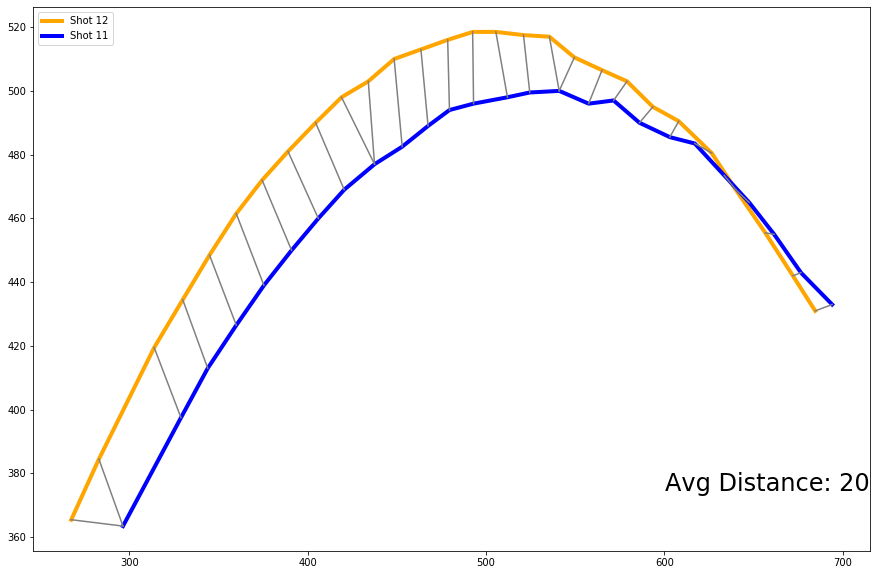

In [206]:
plt.figure(figsize=(15,10))
plot_two_shots(12,11, frame_dim, plt)

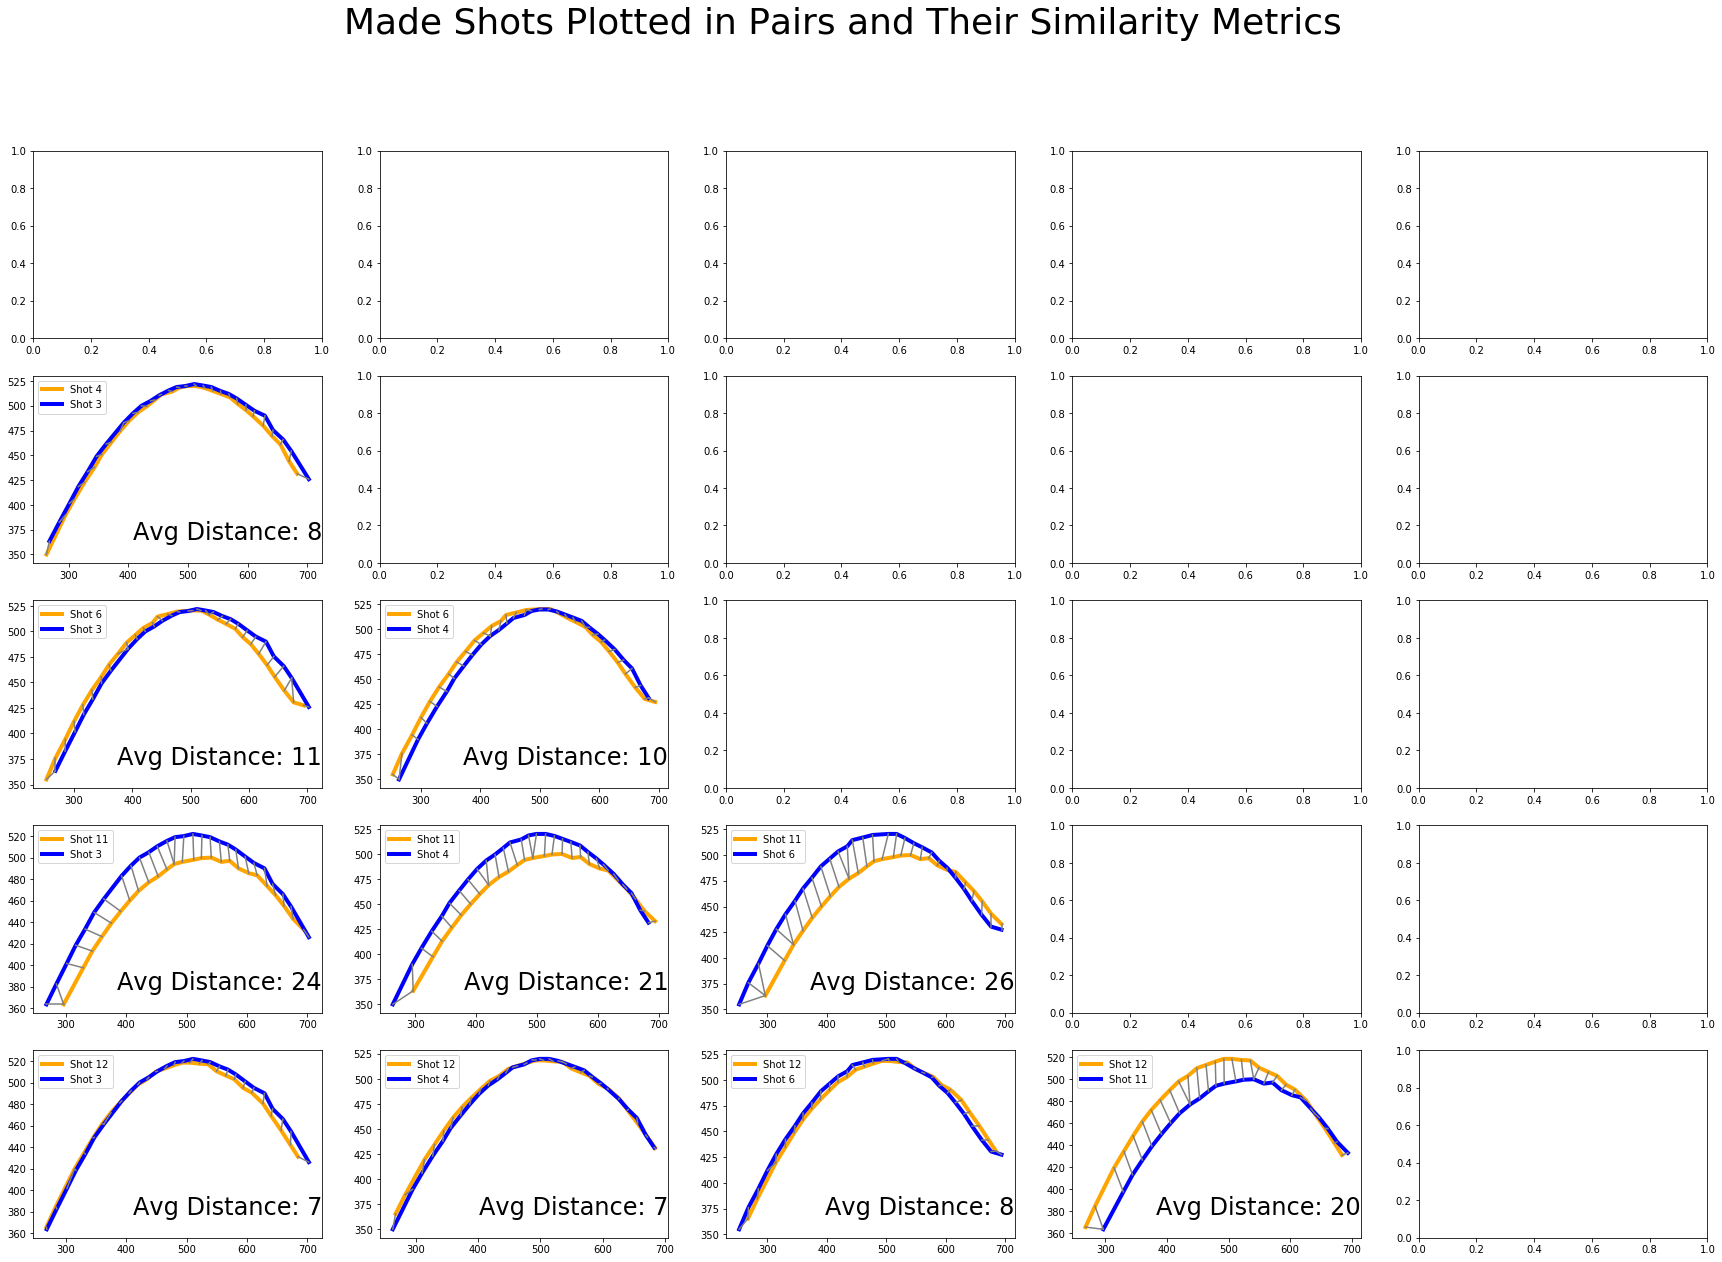

In [207]:
fig, axes = plt.subplots(nrows = 5, ncols = 5, figsize = (30,20))

for i, shot_num_1 in enumerate([3,4,6,11,12]):
    for j, shot_num_2 in enumerate([3,4,6,11,12]):
        if i <= j:
            continue
        plot_two_shots(shot_num_1,shot_num_2, frame_dim, axes[i][j])


plt.suptitle("Made Shots Plotted in Pairs and Their Similarity Metrics", fontsize = 36)
plt.show()